In [12]:
import hydra
import torch
from omegaconf import DictConfig, OmegaConf
from typing import Any, Dict, List, Optional, Tuple, Union
from deprecated import deprecated
from omegaconf import DictConfig
import numpy as np
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils import data

from src.data.process import DefaultTransform
from src.data.loader import BiTemporalDataset, load_levircd_sample
from src.models.commons.mask_process import binarize_mask, extract_object_from_batch
from src.models.segment_anything.utils.transforms import ResizeLongestSide
from src.models.segment_anything.utils.amg import build_point_grid
from src.commons.utils import *
from src.commons.utils_io import load_img
from src.commons.constants import PROJECT_PATH, DEVICE, IMG_SIZE

from hydra.core.global_hydra import GlobalHydra


In [2]:
def load_config(list_kwargs):
    # Initialize the Hydra configuration
    hydra.initialize(config_path="../configs", version_base=None)
    cfg = hydra.compose(config_name="train", overrides=list_kwargs)
    return cfg

GlobalHydra.instance().clear()
list_kwargs = ["experiment=probing_diff", "sam_type=small", "data=levir-cd"]
cfg = load_config(list_kwargs)
#print(OmegaConf.to_yaml(cfg))

In [3]:
def generate_prompt(
    mask, dtype: str, n_point: int, kwargs: Union[Dict, DictConfig]
) -> torch.Tensor:
    """Generate n_point prompts for a mask : grid or sample mode (dtype)"""
    img_size = mask.shape[-1]
    match dtype:
        case "grid":
            point_per_side = int(np.sqrt(n_point))
            prompt = torch.as_tensor(
                generate_grid_prompt(point_per_side, img_size=img_size)
            )
            labels = torch.ones(len(prompt))
        case "sample":
            loc = kwargs.get('loc', "center")
            n_shape = kwargs.get('n_shape', None)
            prompt, labels = PointSampler().sample(mask=mask,  n_point_per_shape=n_point, loc=loc, n_shape=n_shape)
        case _:
            raise ValueError("Please provide valid prompt builder name")

    return prompt.to(torch.float32), labels.to(torch.int8)


In [37]:
class PointSampler:
    """Prompt sampler - restricted to points
    
    Each generated points is under coordinates format (X,Y) in pixels.
    """
    MIN_AREA = 25
    
    def __init__(self):
        self._register_sample_method = {
            "random": self.draw_random_point,
            "center": self.draw_center_point,
        }

    def sample_candidates_shapes(self, shapes: torch.Tensor, n_shape: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # assign equals weights
        probs = torch.ones(shapes.shape[0]) / shapes.shape[0]
        # Sample the shapes
        id_candidates_shapes = torch.multinomial(
            probs,
            n_shape,
            # we sample with replacement to keeping same tensor dimensions over batch if not enough shapes
            replacement=False if (shapes.shape[0] >= n_shape) else True,
        )
        # get the coord of the pixels shapes (M x 3) - M number of not zeros pixels
        coords_candidates = torch.nonzero(shapes[id_candidates_shapes]).to(torch.float)
        return coords_candidates, id_candidates_shapes
        
    def sample(self, mask: torch.Tensor,  n_point_per_shape: int, loc: str, n_shape: int):
        """
        Sample m points over n random shape
        Return new label if a subset of shapes (n_shape) is selected
        """

        if loc not in list(self._register_sample_method):
            raise ValueError(
                f"loc method not valid. Valid values for loc : {list(self._register_sample_method)}"
            )
        if not n_shape:
            raise ValueError("please provide n_shape to sample. One point per shape")
            
        if mask.ndim < 3:
            mask = mask.unsqueeze(0)
        # track id shapes if we a subset of shapes
        id_selected_shapes = None
        
        # extract shapes from mask - squeeze batch dimension
        shapes = extract_object_from_batch(mask).squeeze(0)
        # print("FIND SHAPES", shapes.shape[0])
        # if (n_shape is not None) and (n_shape != shapes.shape[0]):
        #     raise NotImplementedError("Sample of shapes is not implemented yet")

        # filter on areas
        areas = torch.sum(shapes, dim=(1, 2))
        indices = torch.where(areas > self.MIN_AREA)[0]
        shapes = shapes[indices,:,:]

        # check if there is some shapes extracted - check sum for no-shapes return
        # check > 1 first for speed in case of shapes - return no shapes :  (1 x) 1 x H x W
        if shapes.shape[0] > 1 or torch.sum(shapes):
            coords_candidates, id_selected_shapes = self.sample_candidates_shapes(shapes, n_shape)
            # first column of coords_candidates == index of shape
            # iterate over the shapes
            sample_coords = torch.cat(
                [
                    # mask coordinates based on shape index
                    # select only coordinates dims for _register_sample_method : [:, 1:] => (N, 2)
                    self._register_sample_method[loc](
                        coords_candidates[coords_candidates[:, 0] == s][:, 1:], n_point_per_shape
                    )
                    for s in torch.unique(coords_candidates[:, 0])
                ]
            )
            # simulate point type (foreground / background) - foreground default
            labels_points = torch.ones(len(sample_coords))
        else:
            # empty return = sample random points
            print("no return")
            #sample_coords = torch.zeros((n_shape*n_point_per_shape, 2), dtype=torch.float32) - 1000
            print(mask.shape)
            sample_coords = torch.as_tensor(np.random.randint(0, mask.shape[-1], size=(n_shape, 2)))
            # label - 1
            labels_points = torch.zeros(len(sample_coords)) - 1

        return sample_coords, labels_points

    def draw_random_point(self, shape, n_point):
        """draw one random point from shape"""
        idx = torch.multinomial(
            torch.ones(shape.shape[0], dtype=torch.float), num_samples=n_point
        )
        # invert pixels coords to (x, y) format
        return torch.flip(shape[idx], dims=(1,))

    def draw_center_point(self, shape, n_point):
        """
        Sample approximation center. Proxy for hard concave object where "natural center" (simple average) doesn't belong to the shape.
        shape : (M, 2) : (shape's pixels, px coordinates dim)
        """
        # proxy for hard concave object
        visible_center = torch.mean(shape, dim=0).to(int)
        # euclidean distance
        dist_center = torch.cdist(visible_center.unsqueeze(0).to(torch.float), shape, p=2.).view(-1)
        idx = torch.nonzero(dist_center).view(-1)
        dist_center, shape = dist_center[idx], shape[idx,...]
        # sample point from inverse distance weighting => in favor of "closest center" point - take first 50 pts arbitrary
        # values, indices  = torch.topk(dist_center, min(50, dist_center.shape[0]), largest=False, sorted=True)
        # values, indices = values.view(-1), indices.view(-1)
        idx = torch.multinomial(
            1/dist_center, num_samples=n_point
        )
        # flip to convert to (x, y) format
        return torch.flip(shape[idx], dims=(1,))

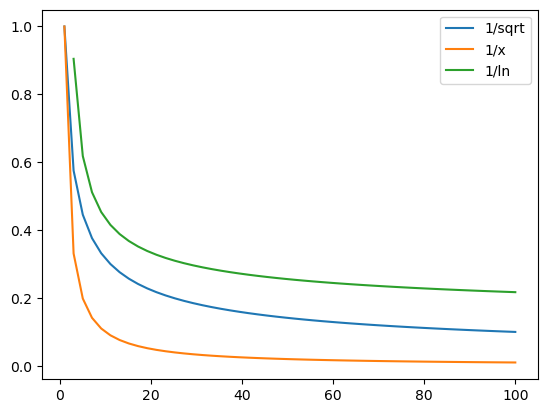

In [38]:
import matplotlib.pyplot as plt
x = np.linspace(1, 100, 50)
plt.plot(x, 1/np.sqrt(x), label="1/sqrt")
plt.plot(x, 1/x, label="1/x")
plt.plot(x, 1/np.log(x), label="1/ln")

plt.legend()

In [39]:
df = load_levircd_sample(None, data_type="test", seed=42)

In [55]:
#idx=65
idx=120

path_label,path_A, path_B = df.iloc[idx]
label = load_img(path_label)

In [56]:
img_A = load_img(path_A)

In [57]:
point_coords, point_labels = generate_prompt(
    torch.as_tensor(label), 
    dtype="sample", 
    n_point=1, 
    kwargs=dict(loc="center", n_shape=3)
)

In [58]:
point_coords

tensor([[ 28., 846.],
        [ 86., 980.],
        [206., 987.]])

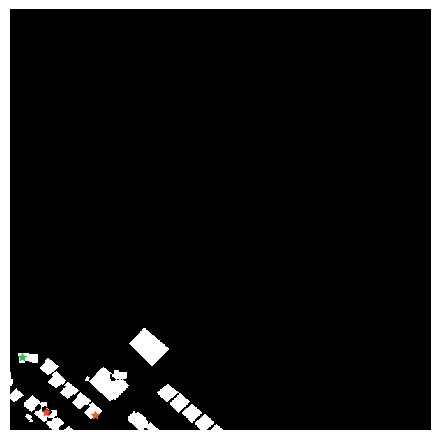

In [59]:
show_img(label)
ax = plt.gca()
colors = [
    np.random.choice(range(256), size=3) / 255
    for _ in range(len(point_coords))
    ]

for pt,c in zip(point_coords, colors):
    ax.scatter(*pt, color=c, marker='*', s=30)


### Run of all batches

In [ ]:
params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape": 3,
    "loc": "center",
    "batch_size": 2,
}
ds = BiTemporalDataset(
        name="levir-cd",
        dtype="train",
        transform=DefaultTransform(),
        params=OmegaConf.create(params),
    )

In [ ]:
dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
        )

In [ ]:
for batch in dloader:
    print(batch["label_path"])

In [10]:
batch = next(iter(dloader))

/home/MDizier/data/dl/levir-cd/train/label/train_1.png
/home/MDizier/data/dl/levir-cd/train/label/train_2.png
